## Import Library

In [125]:
# -*- coding: utf-8 -*-
from scipy.optimize import  curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


## Define functions

In [254]:
def cdf(x, lmda, a, b):
    return (1 - np.exp(-lmda * x -(a / b) * (np.exp(b * x) - 1)))

def pdf(x, lmda, a, b):
    return ((a* np.exp(b * x) + lmda) * np.exp(-lmda * x - (a/b) * (np.exp(b*x) - 1)))


'''
def cdf(x, gamma, b):
    return (1-np.exp(- (b/gamma)*np.exp(gamma*x - 1)))
    
def pdf(x, gamma, b):
    return b * np.exp(gamma * x) * np.exp(-(b/gamma) * (np.exp(gamma * x) - 1))
    return ((a* np.exp(b * x) + lmda) * np.exp(-lmda * x - (a/b) * (np.exp(b*x) - 1)))
'''
def scale_fit(func, x, y):
    norm = preprocessing.StandardScaler()
    data = [[x[i], y[i]] for i in range(len(x))]
    data_ = norm.fit_transform(data)
    popt, pcov = curve_fit(func, data_[:,0] , data_[:,1], bounds=[0,[100,100,100]])
    return popt, pcov, norm

def scale_predict(func, norm, x, popt):
    yhat = func(x, popt[0], popt[1], popt[2])
    data_ = [x,yhat]
    data = norm.inverse_transform([data_])
    return data[:,1]

## Data preperation

In [127]:
age_popu=pd.read_excel('./data/WPP2022_POP_F02_1_POPULATION_5-YEAR_AGE_GROUPS_BOTH_SEXES.xlsx')

<BarContainer object of 21 artists>

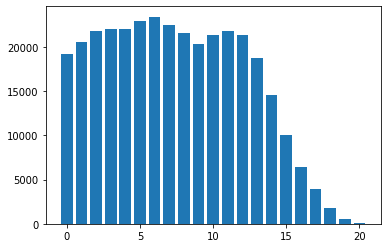

In [383]:
popu=age_popu.iloc[18523,11:]
plt.bar(range(0, len(popu)),popu)

In [129]:
# Set the maximum age at 150-years-old so that the model can predict age over 100
age = np.linspace(0.04, 0.99, 20, dtype="float64")
fit_age = np.append(np.array([0],dtype='float64'), 
                    np.append(age, np.array([1.49],dtype='float64')), 
                    axis=None)

# Number of death per age group
age_death = [0, 3_880, 2_354, 3_217, 10_886, 21_139, 28_276, 31_939, 36_901, 42_895, 65_698, 
           104_444, 162_098, 209_908, 248_087, 283_523, 307_498, 350_261, 388_121, 319_443, 
           141_108, 29_363]

# Portion of cancer (in death)
mn_po = [0, 8.4, 17.8, 13.6, 5.1, 3.9, 4.6, 7.2, 11.1, 15.8, 20, 
         25, 29.4, 32, 32.9, 30.6, 26.7, 21.1, 15.4, 10.4, 6.7, 4.0]


# Compute the Mortality rate of 'cancer group' in U.S.
mn_death_cul = [0]
for i in range(len(age_death)):
    mn_death_cul.append( mn_death_cul[-1] + (mn_po[i] / 100) * age_death[i])
mn_mr = np.array([i/mn_death_cul[-1] for i in mn_death_cul], dtype="float64") 
mn_mr = mn_mr[1:] # Delete the repeated first 0 term

## Data Check

In [131]:
table1=pd.DataFrame({'Age Group(Endpoint)':fit_age, 'Number of Death':age_death, 
                     'Portion of Death of THis Disease %': mn_po, 'Accumulated Mortality Rate': mn_mr})
table1

,Age Group(Endpoint),Number of Death,Portion of Death of THis Disease %,Accumulated Mortality Rate
0,0.00,0,0.0,0.000000
1,0.04,3880,8.4,0.000544
2,0.09,2354,17.8,0.001243
3,0.14,3217,13.6,0.001974
4,0.19,10886,5.1,0.002900
5,0.24,21139,3.9,0.004276
6,0.29,28276,4.6,0.006447
7,0.34,31939,7.2,0.010286
8,0.39,36901,11.1,0.017122
9,0.44,42895,15.8,0.028435


## Fit the Gompertz-Makeham curve

### Part 1: CDF 

Text(0.5, 1.0, 'Expected Age of Malignant neoplasms:70.88')

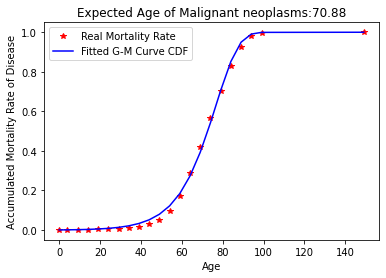

In [340]:
# Fit the G-M curve
bounds=[0,[100,100,100]]
popt_cdf, pcov_cdf = curve_fit(cdf, fit_age, mn_mr,bounds=bounds, maxfev = 50_000)

pre_mr = [cdf(i, popt_cdf[0], popt_cdf[1], popt_cdf[2]) for i in fit_age]

# Compute the expected age by using differential of CDF
n = 151
age_slice = np.linspace(0,1.5,151)
Expected_Age = sum([100 * age_slice[i] * (cdf(age_slice[i], popt_cdf[0], popt_cdf[1], popt_cdf[2])
                                          -cdf(age_slice[i-1], popt_cdf[0], popt_cdf[1], popt_cdf[2]))
                    for i in range(1, n)])

plt.plot([i*100 for i in fit_age], mn_mr,'r*', 
         [i*100 for i in fit_age], pre_mr, 'b')
plt.legend(['Real Mortality Rate', 'Fitted G-M Curve CDF'])
plt.xlabel('Age')
plt.ylabel('Accumulated Mortality Rate of Disease')
plt.title(f'Expected Age of Malignant neoplasms:{round(Expected_Age,2)}')

In [281]:
cdf(1.15, popt_cdf[0], popt_cdf[1], popt_cdf[2])


0.9999999999999479

### Part 2: PDF

Text(0.5, 1.0, 'Expected Age of Malignant neoplasms:70.88')

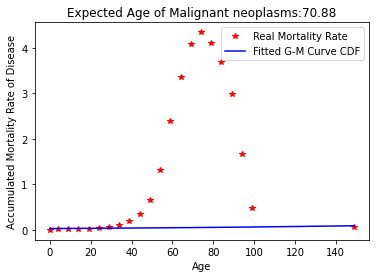

In [333]:
mn_death_disc = []
norm = preprocessing.MinMaxScaler()

for i in range(len(age_death)):
    mn_death_disc.append((mn_po[i] / 100) * age_death[i])
mn_mr_pdf = [ (each / sum(mn_death_disc)) for each in mn_death_disc]
# Normalization: map the sample point to [0, 1] interval
'''
mn_mr_pdf_ = [100*(each - min(mn_mr_pdf))
              /(max(mn_mr_pdf) - min(mn_mr_pdf)) 
              for each in mn_mr_pdf]
'''
mn_mr_pdf_ = [100 *each for each in mn_mr_pdf]
fit_age_ = [age*10 for age in fit_age]
popt_pdf, pcov_pdf = curve_fit(pdf, fit_age, mn_mr_pdf, bounds=bounds, p0 = popt_cdf, maxfev = 20_000)

# Predict the mortality rate of cancer
pre_mr_pdf = [pdf(i, popt_pdf[0], popt_pdf[1], popt_pdf[2]) for i in fit_age]

plt.plot([i*100 for i in fit_age], mn_mr_pdf_,'r*', 
         [i*100 for i in fit_age], pre_mr_pdf, 'b')
plt.legend(['Real Mortality Rate', 'Fitted G-M Curve CDF'])
plt.xlabel('Age')
plt.ylabel('Accumulated Mortality Rate of Disease')
plt.title(f'Expected Age of Malignant neoplasms:{round(Expected_Age,2)}')

+ However, I guess here is the reason why we can not fit it perfectly:
  + the value we obtained from data is actually an integration of a 5 year group, which is an accumulated pobability, so we can not find the true pobability density function sample point at a specific point, taking the age group [5, 9] as an example:
  + $$0.000544 = \int_5^9 PDF(age, coef)d_{age}$$
  + As a result, we can not get the true pdf function, the next graph shows that we can approximate PDF by using the coefficients of CDF, which implies that the coefficients of CDF and PDF are actually the same.

In [305]:
table2=pd.DataFrame({'Age Group(Endpoint)':fit_age, 'Accumulated Mortality Rate': mn_mr, 
                     'Mortality Rate': mn_mr_pdf})
table2.to_csv('Cancer_Mortality.csv')
table2


,Age Group(Endpoint),Accumulated Mortality Rate,Mortality Rate
0,0.00,0.000000,0.000000
1,0.04,0.000544,0.000544
2,0.09,0.001243,0.000699
3,0.14,0.001974,0.000730
4,0.19,0.002900,0.000927
5,0.24,0.004276,0.001376
6,0.29,0.006447,0.002171
7,0.34,0.010286,0.003838
8,0.39,0.017122,0.006837
9,0.44,0.028435,0.011312


Text(0.5, 1.0, 'Expected Age of Malignant neoplasms:70.88')

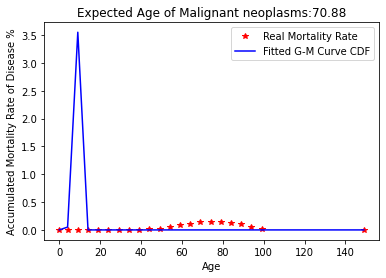

In [292]:
pre_mr_pdf = [pdf(i, popt_cdf[0], popt_cdf[1], popt_pdf[2])*0.1 for i in fit_age]

plt.plot([i*100 for i in fit_age], mn_mr_pdf,'r*', 
         [i*100 for i in fit_age], pre_mr_pdf, 'b')
plt.legend(['Real Mortality Rate', 'Fitted G-M Curve CDF'])
plt.xlabel('Age')
plt.ylabel('Accumulated Mortality Rate of Disease %')
plt.title(f'Expected Age of Malignant neoplasms:{round(Expected_Age,2)}')

+ For each sample point in the graph, we approximate it by using the PDF with the coefficients come from CDF, then sum it up and multiplied it by the steps, which is:
  + $$0.000544=\int_5^9 PDF(age, coef_{CDF})d_{age}$$
  + And by taking more small steps, the curve will be more closer to the sample points.

Text(0.5, 1.0, 'Expected Age of Malignant neoplasms:70.88')

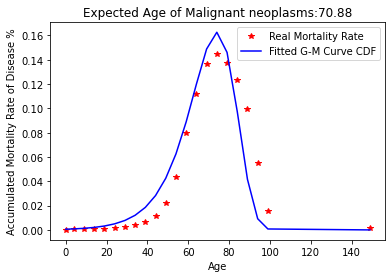

In [304]:
pre_mr_pdf = [0.01 * sum([pdf(j, popt_cdf[0], popt_cdf[1], popt_cdf[2]) 
                          for j in np.linspace(i, i+0.05,5)])
              for i in fit_age]

plt.plot([i*100 for i in fit_age], mn_mr_pdf,'r*', 
         [i*100 for i in fit_age], pre_mr_pdf, 'b')
plt.legend(['Real Mortality Rate', 'Fitted G-M Curve PDF'])
plt.xlabel('Age')
plt.ylabel('Accumulated Mortality Rate of Disease')
plt.title(f'Expected Age of Malignant neoplasms:{round(Expected_Age,2)}')

## Another charts

Text(0.5, 1.0, 'Mortality Distribution')

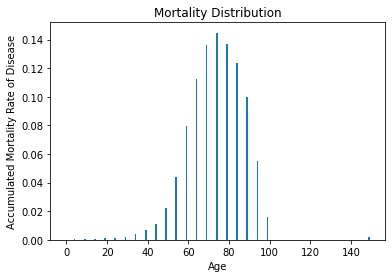

In [379]:
pre_mr_pdf = [0.01 * sum([pdf(j, popt_cdf[0], popt_cdf[1], popt_cdf[2]) 
                          for j in np.linspace(i, i+0.05,5)])
              for i in fit_age]

plt.bar([i*100 for i in fit_age], mn_mr_pdf)
plt.xlabel('Age')
plt.ylabel('Accumulated Mortality Rate of Disease')
plt.title('Mortality Distribution')

Text(0.5, 1.0, 'G-M Mortality Distribution')

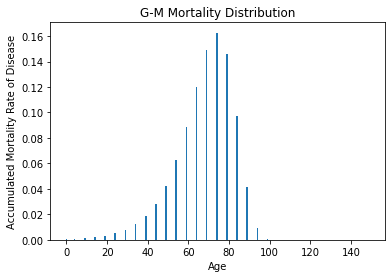

In [380]:
pre_mr_pdf = [0.01 * sum([pdf(j, popt_cdf[0], popt_cdf[1], popt_cdf[2]) 
                          for j in np.linspace(i, i+0.05,5)])
              for i in fit_age]

plt.bar([i*100 for i in fit_age], pre_mr_pdf)
plt.xlabel('Age')
plt.ylabel('Accumulated Mortality Rate of Disease')
plt.title('G-M Mortality Distribution')

## Compute the expected lifespan

$$
N_{yes}*Age_{yes}+N_{no}*Age_{no}=N_{all}*Age_{all}\\\to Age_{cure}=Age_{no}=\frac{N_{all}*Age_{all}-N_{yes}*Age_{yes}}{N_{no}}
$$

In [358]:
Age_all = 76.1 # Not sure yet, need more authoritative data
N_all = sum(popu)* 1000
# Assume the percentage of people who have cancer is the portion of people who died from cancer
N_yes = (sum([age_death[i] * mn_po[i] / 100 for i in range(len(mn_po))])/sum(age_death))*N_all
Age_yes = Expected_Age

Age_cure = ((N_all * Age_all - N_yes * Age_yes)
            /(N_all - N_yes))
Age_span = Age_cure - Age_all
Age_span

1.4265338394393865

+ So the expected lifespan in U.S. if we can cure cancer is 1.43 years

([<matplotlib.patches.Wedge at 0x290a82b77c0>,
 [Text(0.8592103155007879, 0.6868461499761331, 'Malignant Neoplasms: 21%'),
  Text(-0.9373203441826776, -0.7492867090648726, 'Others: 79%')])

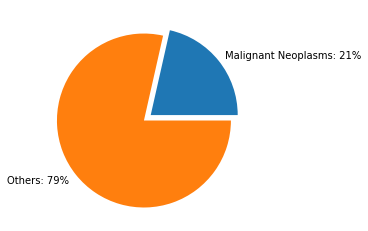

In [378]:
plt.pie([N_yes,N_all-N_yes],[0,0.1],[f'Malignant Neoplasms: {round(100*N_yes/(N_all))}%',
                                     f'Others: {round(100*(N_all-N_yes)/(N_all))}%'])


In [ ]:
plt.